# 拡散過程の可視化
観測データの分布をダミーで作り、これらがノイズが加えられていくと、どの様に観測データ分布が変化していくかを可視化する。


### 観測データ
2つの1次元ガウス分布を混合した混合ガウス分布からサンプリングしたデータを用いる。  
これを確率変数$\bold{x_0}$ とする。
- $ n=2$
- $ \mu_n \in \mathbb{R}  $: n番目のガウス分布の平均
- $ \sigma_n \in \mathbb{R}^+ $: n番目のガウス分布の標準偏差
- $ w_n $: n番目分布の混合割合
- $ \sum_{i=1}^{n} n_i = 1$

$$
f_n(x) = \frac{1}{\sqrt{2 \pi \sigma_n^2}} \exp\left( -\frac{(x - \mu_n)^2}{2 \sigma_n^2} \right)  \\
\text{  }\\
 
f(\bold{x_0} = x) = w_1 f_1(x) + w_2 f_2(x)
$$

## 拡散過程
拡散過程は、観測変数にノイズを徐々に加えていき、最終的にノイズのみの分布( $\bold{x}_T $)にする過程のことである。  
拡散過程の式は、DDPM(Denoising Diffusion Probabilistic Models)を用いる。

ステップを $t$ として、確率変数 $\bold{x}_{t-1}$ から $\bold{x}_t$ への条件付き確率を以下の式で表す。
$$
q(\bold{x}_t|\bold{x}_{t-1}) := \mathcal{N}(\bold{x}_t; \sqrt{\alpha_t}\bold{x}_{t-1}, \beta_t) \\ 
\text{  } \\
$$

データ分布を徐々にノイズ飲みの分布に変化させるために、分散を徐々に大きくする。( $ 0< \beta_1 < \beta_2 < ... < \beta_T < 1$ )  
また、$\alpha_t := 1 - \beta_t$ と定義する。  
この様に定義すると、$T$が大きくなるにつれて、$\beta$は、1に近づき、$\alpha$は0に近づくため、$ q(\bold{x}_T|\bold{x}_{T-1}) \approx \mathcal{N}(\bold{x}_T; 0, 1) $となる。  
また、この式は、$ \bold{x}_{T-1} $に関係しないし気になるため、周辺確率が平均0,分散1の平均分布と見なすことができる。

In [8]:
import numpy as np 
import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib
import japanize_matplotlib

# サンプルデータの生成
np.random.seed(0)

np.__version__, matplotlib.__version__, sns.__version__

('1.22.4', '3.5.2', '0.13.2')

## 観測分布の生成

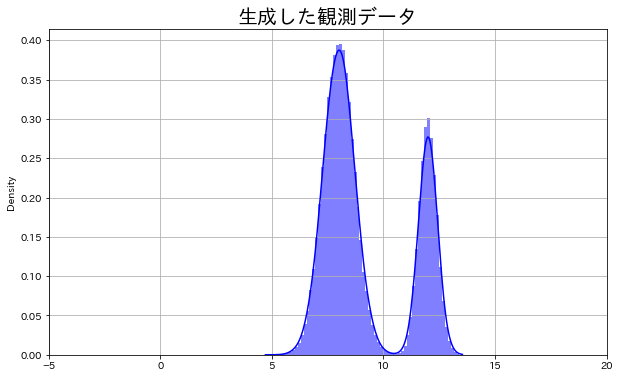

In [9]:
# 全体のサンプルリング数
n = 200_000

# 2つの1次元ガウス分布の定義
mean1, std1, pi1 = 12, 0.4, 0.3  
mean2, std2, pi2 = 8, 0.7, 1-pi1  
n1 = int(pi1 * n)
n2 = n - n1

# データ生成(観測データ)
data1 = np.random.normal(mean1, std1, n1)
data2 = np.random.normal(mean2, std2, n2)
measured_data = np.concatenate([data1, data2])


# プロット(確率密度を描画する)
plt.figure(figsize=(10, 6))
sns.histplot(measured_data, kde=True, stat='density', linewidth=0, color='blue')
plt.title('生成した観測データ', fontsize=20)
plt.xlim(-5, 20)
plt.grid()
plt.show()

## 拡散過程の定義

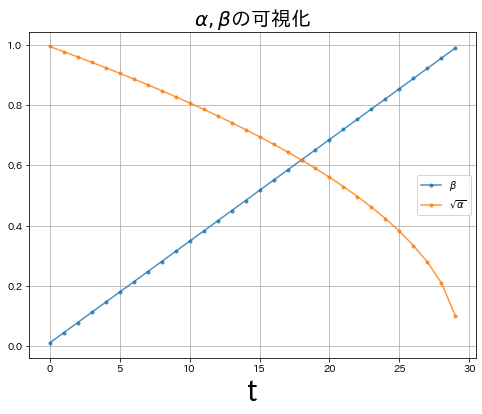

In [10]:
# 総ステップ数(拡散を実施する回数)
T = 30

betas = np.linspace(0.01, 0.99, T)
alphas = 1 - betas

plt.figure(figsize=(8, 6))
plt.plot(betas, marker="o", label=r'$ \beta $', markersize=3, alpha=0.8)
plt.plot(np.sqrt(alphas), marker='o', label=r'$ \sqrt{\alpha} $', markersize=3, alpha=0.8)
plt.xlabel('t', fontsize=30)
plt.title(r'$ \alpha, \beta $の可視化', fontsize=20)
plt.legend()
plt.grid()
plt.show()

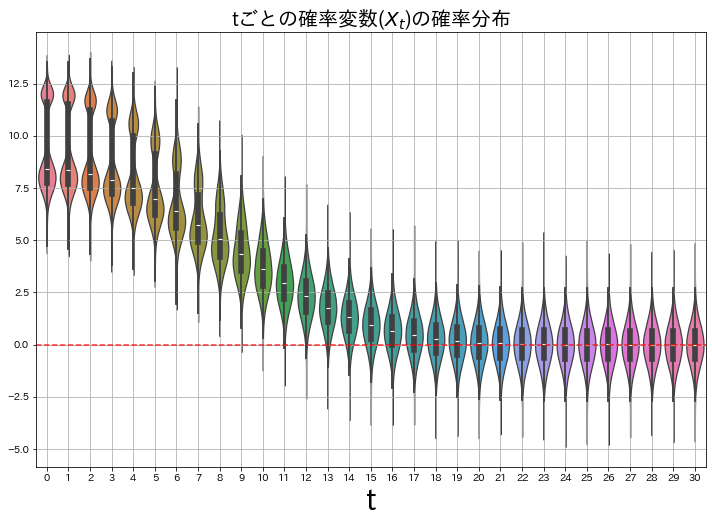

In [11]:
datas = [measured_data]

data_t = measured_data
for t in range(T):
    # 拡散する
    data_t = np.random.normal(loc=np.sqrt(alphas[t]) * data_t, scale=np.sqrt(betas[t]))
    datas.append(data_t)
    
plt.figure(figsize=(12, 8))
sns.violinplot(datas)
plt.axhline(0, color='red', alpha=0.8, linestyle='--')
plt.title('tごとの確率変数($X_t$)の確率分布', fontsize=20)
plt.xlabel('t', fontsize=30)
plt.grid()
plt.show()

### Visualize using tensorboard
tensorboardで、画像の様なヒストグラムの軌跡を見る 

<img width=500 src='imgs/tenroboard_diffusion_process.png'>

In [12]:
import tensorflow as tf

log_dir = 'logs/diffusion_process/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir=log_dir)


tag_name = 'diffusion_process'
with file_writer.as_default():
    # 観測データを記録 (t=0)
    tf.summary.histogram(tag_name, measured_data, step=0)
    
    for t, data_t in enumerate(datas, start=1):
        tf.summary.histogram(tag_name, data_t, step=t)

# tensorboardを起動して、拡散過程を見る。
# ブラウザからlocalhost:6006にアクセス
!tensorboard --logdir=logs/diffusion_process --port=6006

/Users/shitomiryuta/miniforge3/envs/tf/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
